In [1]:
# Utility libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
# Core libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size':20})

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [3]:
# Load the TensorBoard notebook extension (for visualization purposes)
%load_ext tensorboard

In [4]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 256, 256, 3
loss_function = categorical_crossentropy
no_classes = 10
no_epochs = 50
# optimizer = SGD(learning_rate=0.002, momentum=0.9)
optimizer = "Adam"
# weight_decay = 0.05
learning_rate = 0.1
lmbd = 0.05
c_lmbd = 0.0005
validation_split = 0.2
verbosity = 1

input_shape = (img_width, img_height, img_num_channels)

In [5]:
>>> gpu_available = tf.test.is_gpu_available()
>>> is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
>>> is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-06-15 11:05:24.910868: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 11:05:25.333939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 12673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-06-15 11:05:25.335343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 12673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6
2022-06-15 11:05:25.336070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 12673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 

## ConvNet definition

In [6]:
model = Sequential()
model.add(Conv2D(48, (3, 3), activation='relu', kernel_regularizer=l2(c_lmbd), 
                 padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(48, (3, 3), activation='relu', kernel_regularizer=l2(c_lmbd), 
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(96, (3, 3), activation='relu', kernel_regularizer=l2(c_lmbd), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3), activation='relu', kernel_regularizer=l2(c_lmbd), 
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.3))

model.add(Conv2D(192, (3, 3), activation='relu', kernel_regularizer=l2(c_lmbd), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(192, (3, 3), activation='relu', kernel_regularizer=l2(c_lmbd), 
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(lmbd)))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(lmbd)))
#model.add(Dropout(0.5))
model.add(Dense(no_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 48)      1344      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 48)     192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 48)      20784     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 48)     192       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 48)     0         
 )                                                               
                                                        

2022-06-15 11:05:28.436152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12673 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


## Flickr dataset

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
matplotlib.style.use('default')

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# first download dataset into "flickr" folder
train_generator = train_datagen.flow_from_directory(
    'flickr/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'flickr/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 16354 images belonging to 10 classes.
Found 1827 images belonging to 10 classes.


In [12]:
# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
# Define early stopping for the model training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [14]:
# Clear any logs from previous runs
!rm -rf ./logs/

# Set up a log folder in which we will store the output to be displayed on TensorBoard
logdir = os.path.abspath("logs_cnn/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir)

In [17]:
# Fit data to model

history = model.fit(train_generator,
                    steps_per_epoch= len(train_generator.classes) // batch_size,
                    epochs=no_epochs,
                    validation_data=validation_generator,
                    verbose=verbosity,
                    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50


2022-06-14 18:14:22.950922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-06-14 18:14:23.767293: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-14 18:14:24.250402: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


511/511 [==============================] - 55s 100ms/step - loss: 37.6983 - accuracy: 0.2196 - val_loss: 11.3571 - val_accuracy: 0.2326
Epoch 2/50
511/511 [==============================] - 50s 98ms/step - loss: 8.8379 - accuracy: 0.2690 - val_loss: 6.4762 - val_accuracy: 0.2819
Epoch 3/50
511/511 [==============================] - 50s 98ms/step - loss: 5.4619 - accuracy: 0.2786 - val_loss: 4.4925 - val_accuracy: 0.3093
Epoch 4/50
511/511 [==============================] - 50s 98ms/step - loss: 3.9953 - accuracy: 0.2857 - val_loss: 3.5918 - val_accuracy: 0.3065
Epoch 5/50
511/511 [==============================] - 50s 98ms/step - loss: 3.1853 - accuracy: 0.2910 - val_loss: 2.9088 - val_accuracy: 0.2967
Epoch 6/50
511/511 [==============================] - 50s 99ms/step - loss: 2.6865 - accuracy: 0.3030 - val_loss: 2.4733 - val_accuracy: 0.3049
Epoch 7/50
511/511 [==============================] - 50s 98ms/step - loss: 2.5269 - accuracy: 0.3011 - val_loss: 2.5422 - val_accuracy: 0.2813


In [23]:
# Visualize the model
%tensorboard --logdir {logdir}

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

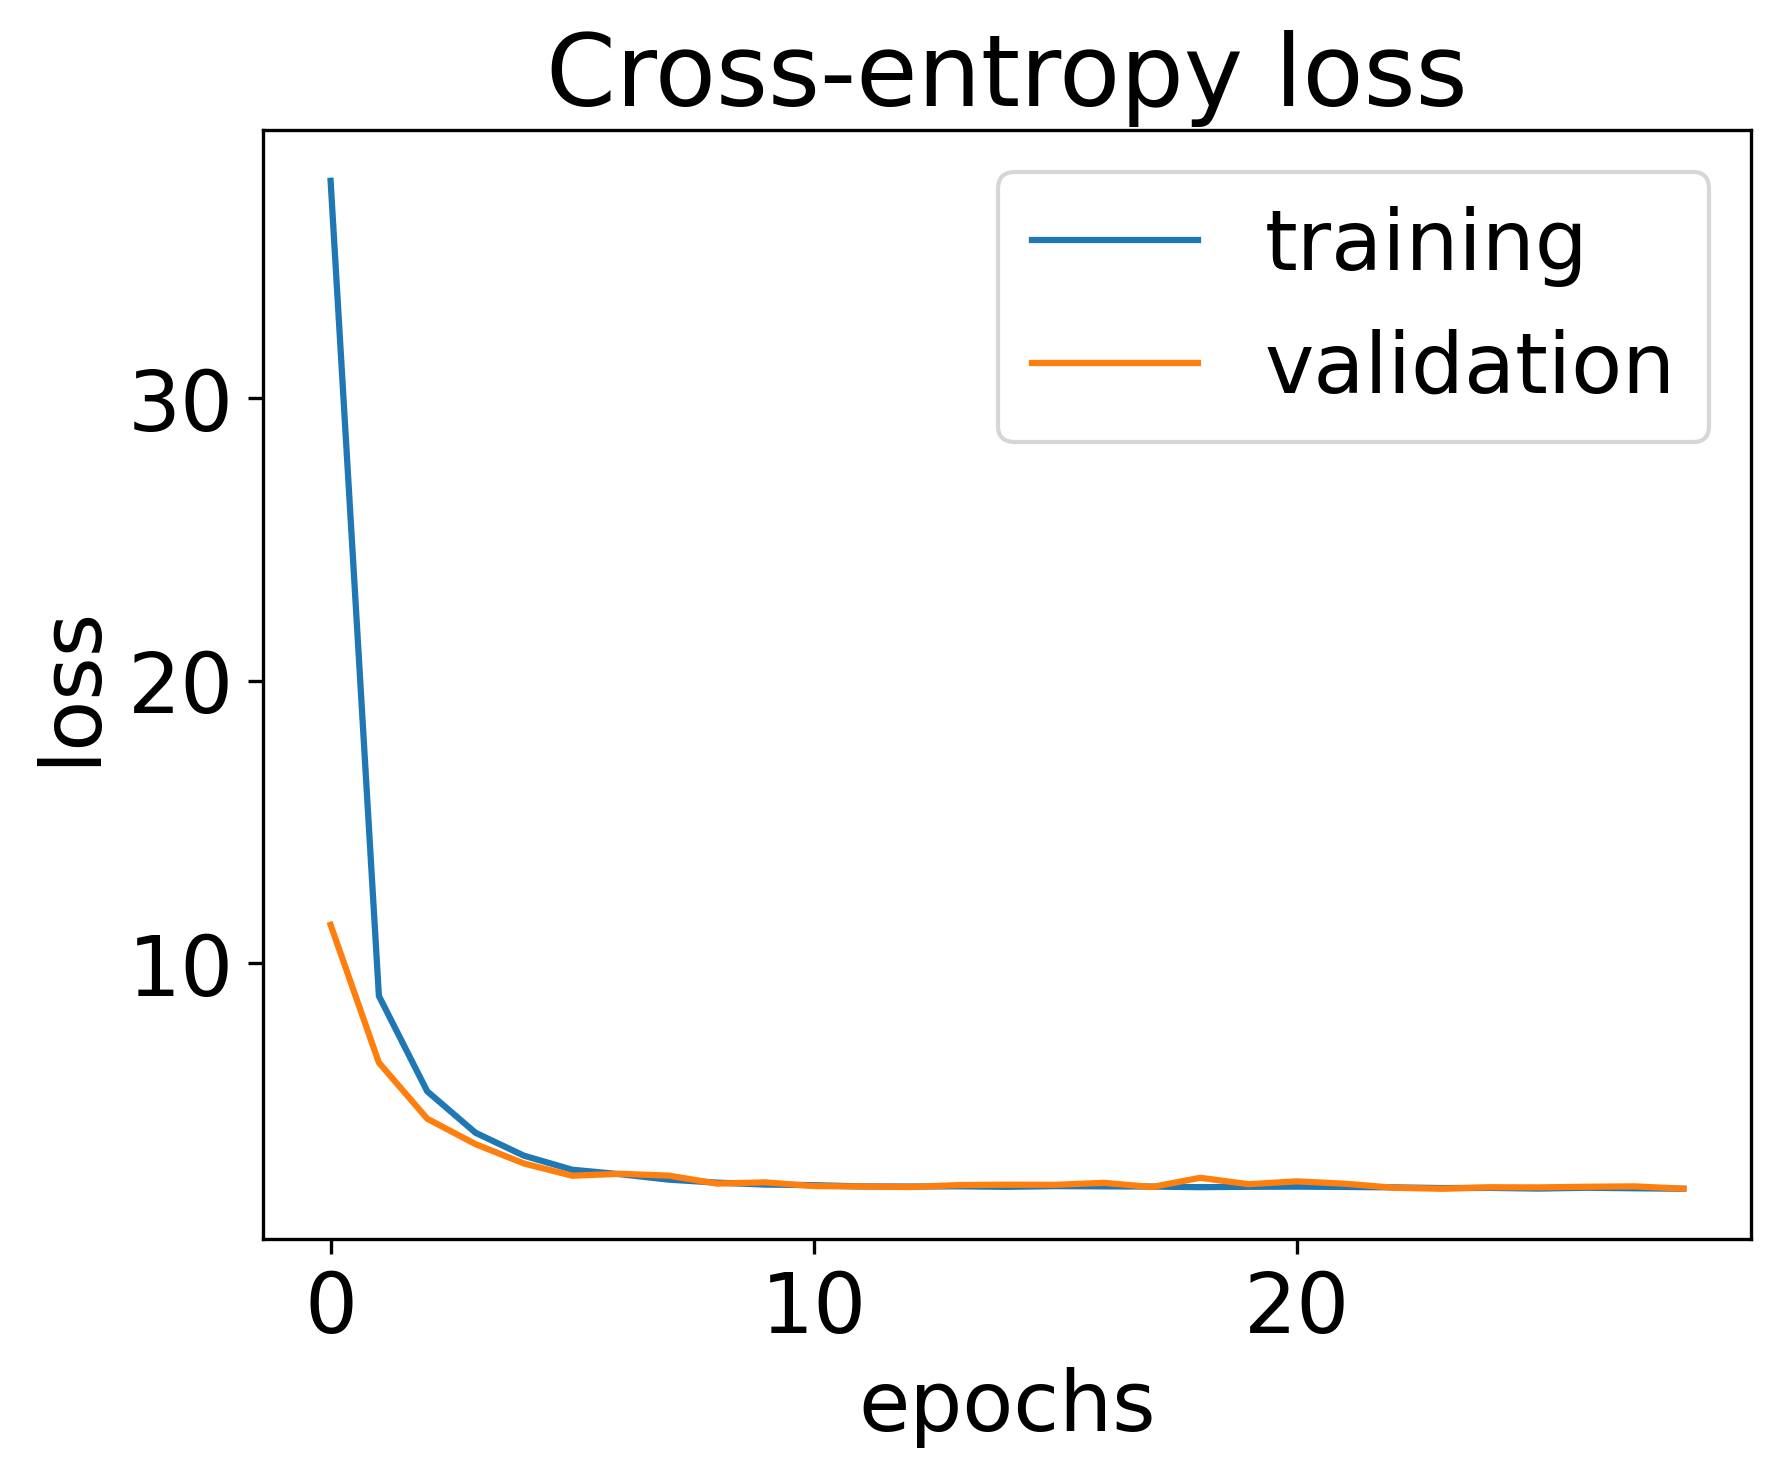

In [27]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Cross-entropy loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('img/flickr_loss.png')
plt.show()

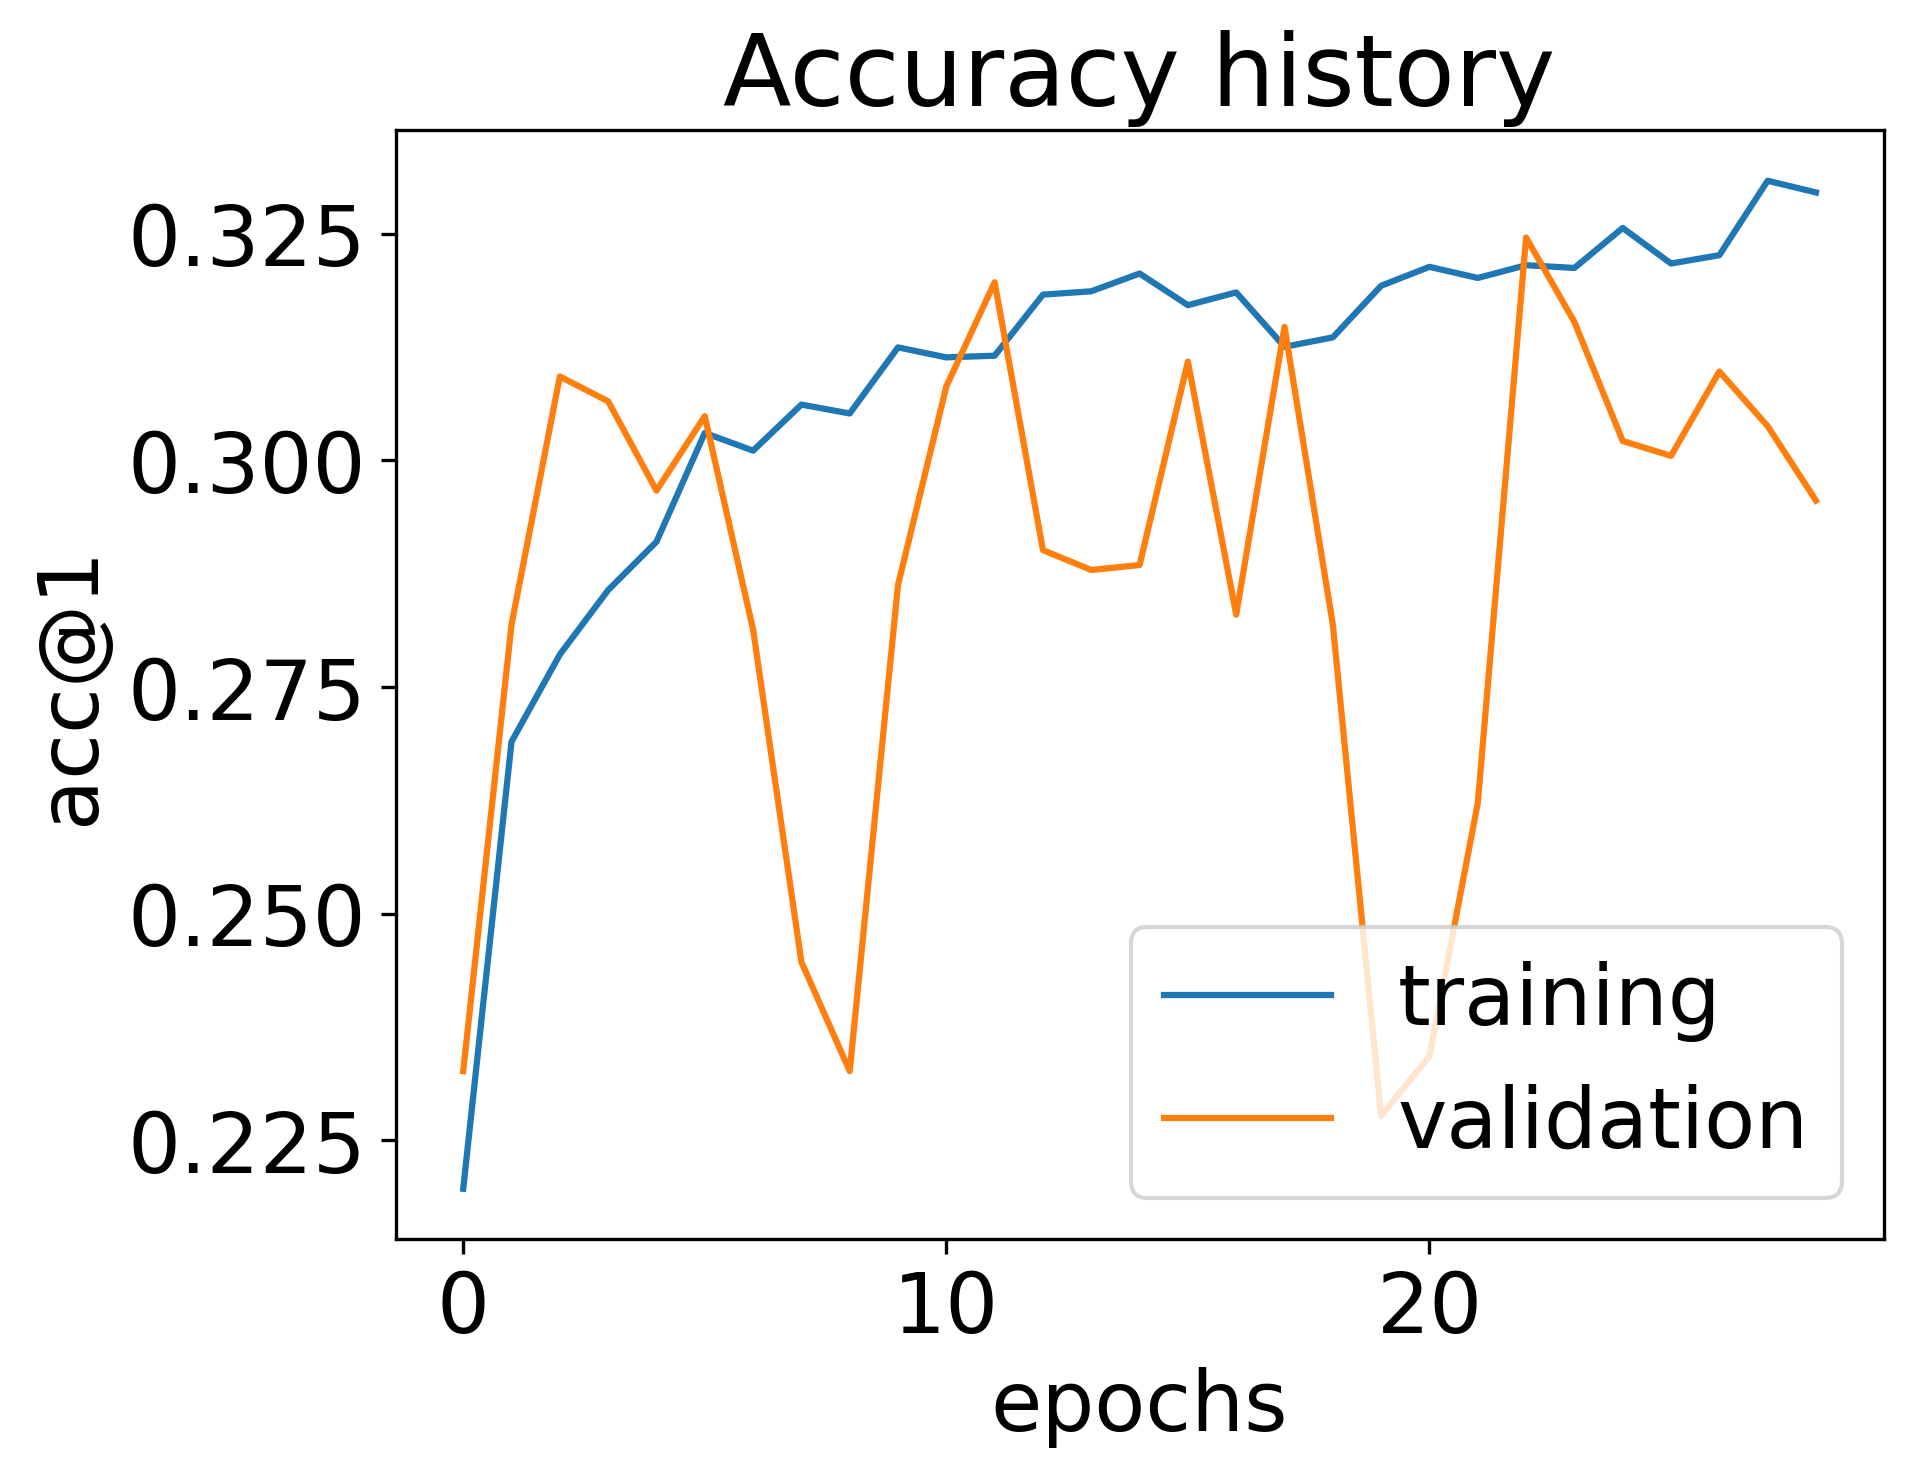

In [28]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy history')
plt.ylabel('acc@1')
plt.xlabel('epochs')
plt.legend(loc='lower right')
# plt.savefig('img/flickr_acc@1.png')
plt.show()

In [29]:
score = model.evaluate(validation_generator, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 2.0135087966918945 / Test accuracy: 0.31527093052864075


## Confusion matrix

In [30]:
# first download dataset into "flickr" folder
target_names = os.listdir('flickr/val/')

In [31]:
y_prob = model.predict(validation_generator) 
y_pred = y_prob.argmax(axis=-1)

In [32]:
#Get the confusion matrix
cf_matrix = confusion_matrix(validation_generator.classes, y_pred, normalize='true')

print(cf_matrix)

[[0.45185185 0.         0.         0.         0.         0.
  0.         0.         0.54814815 0.        ]
 [0.41823899 0.         0.         0.         0.         0.
  0.         0.         0.58176101 0.        ]
 [0.43915344 0.         0.         0.         0.         0.
  0.         0.         0.56084656 0.        ]
 [0.29545455 0.         0.         0.         0.         0.
  0.         0.         0.70454545 0.        ]
 [0.47311828 0.         0.         0.         0.         0.
  0.         0.         0.52688172 0.        ]
 [0.46808511 0.         0.         0.         0.         0.
  0.         0.         0.53191489 0.        ]
 [0.46969697 0.         0.         0.         0.         0.
  0.         0.         0.53030303 0.        ]
 [0.40983607 0.         0.         0.         0.         0.
  0.         0.         0.59016393 0.        ]
 [0.43589744 0.         0.         0.         0.         0.
  0.         0.         0.56410256 0.        ]
 [0.47169811 0.         0.         0.

In [33]:
cm_df = pd.DataFrame(cf_matrix)

for column in cm_df.columns:
    cm_df[column] = cm_df[column].apply(lambda x: f'{x:.2f}'.lstrip('0'))

cm_df

,0,1,2,3,4,5,6,7,8,9
0,.45,.00,.00,.00,.00,.00,.00,.00,.55,.00
1,.42,.00,.00,.00,.00,.00,.00,.00,.58,.00
2,.44,.00,.00,.00,.00,.00,.00,.00,.56,.00
3,.30,.00,.00,.00,.00,.00,.00,.00,.70,.00
4,.47,.00,.00,.00,.00,.00,.00,.00,.53,.00
5,.47,.00,.00,.00,.00,.00,.00,.00,.53,.00
6,.47,.00,.00,.00,.00,.00,.00,.00,.53,.00
7,.41,.00,.00,.00,.00,.00,.00,.00,.59,.00
8,.44,.00,.00,.00,.00,.00,.00,.00,.56,.00
9,.47,.00,.00,.00,.00,.00,.00,.00,.53,.00


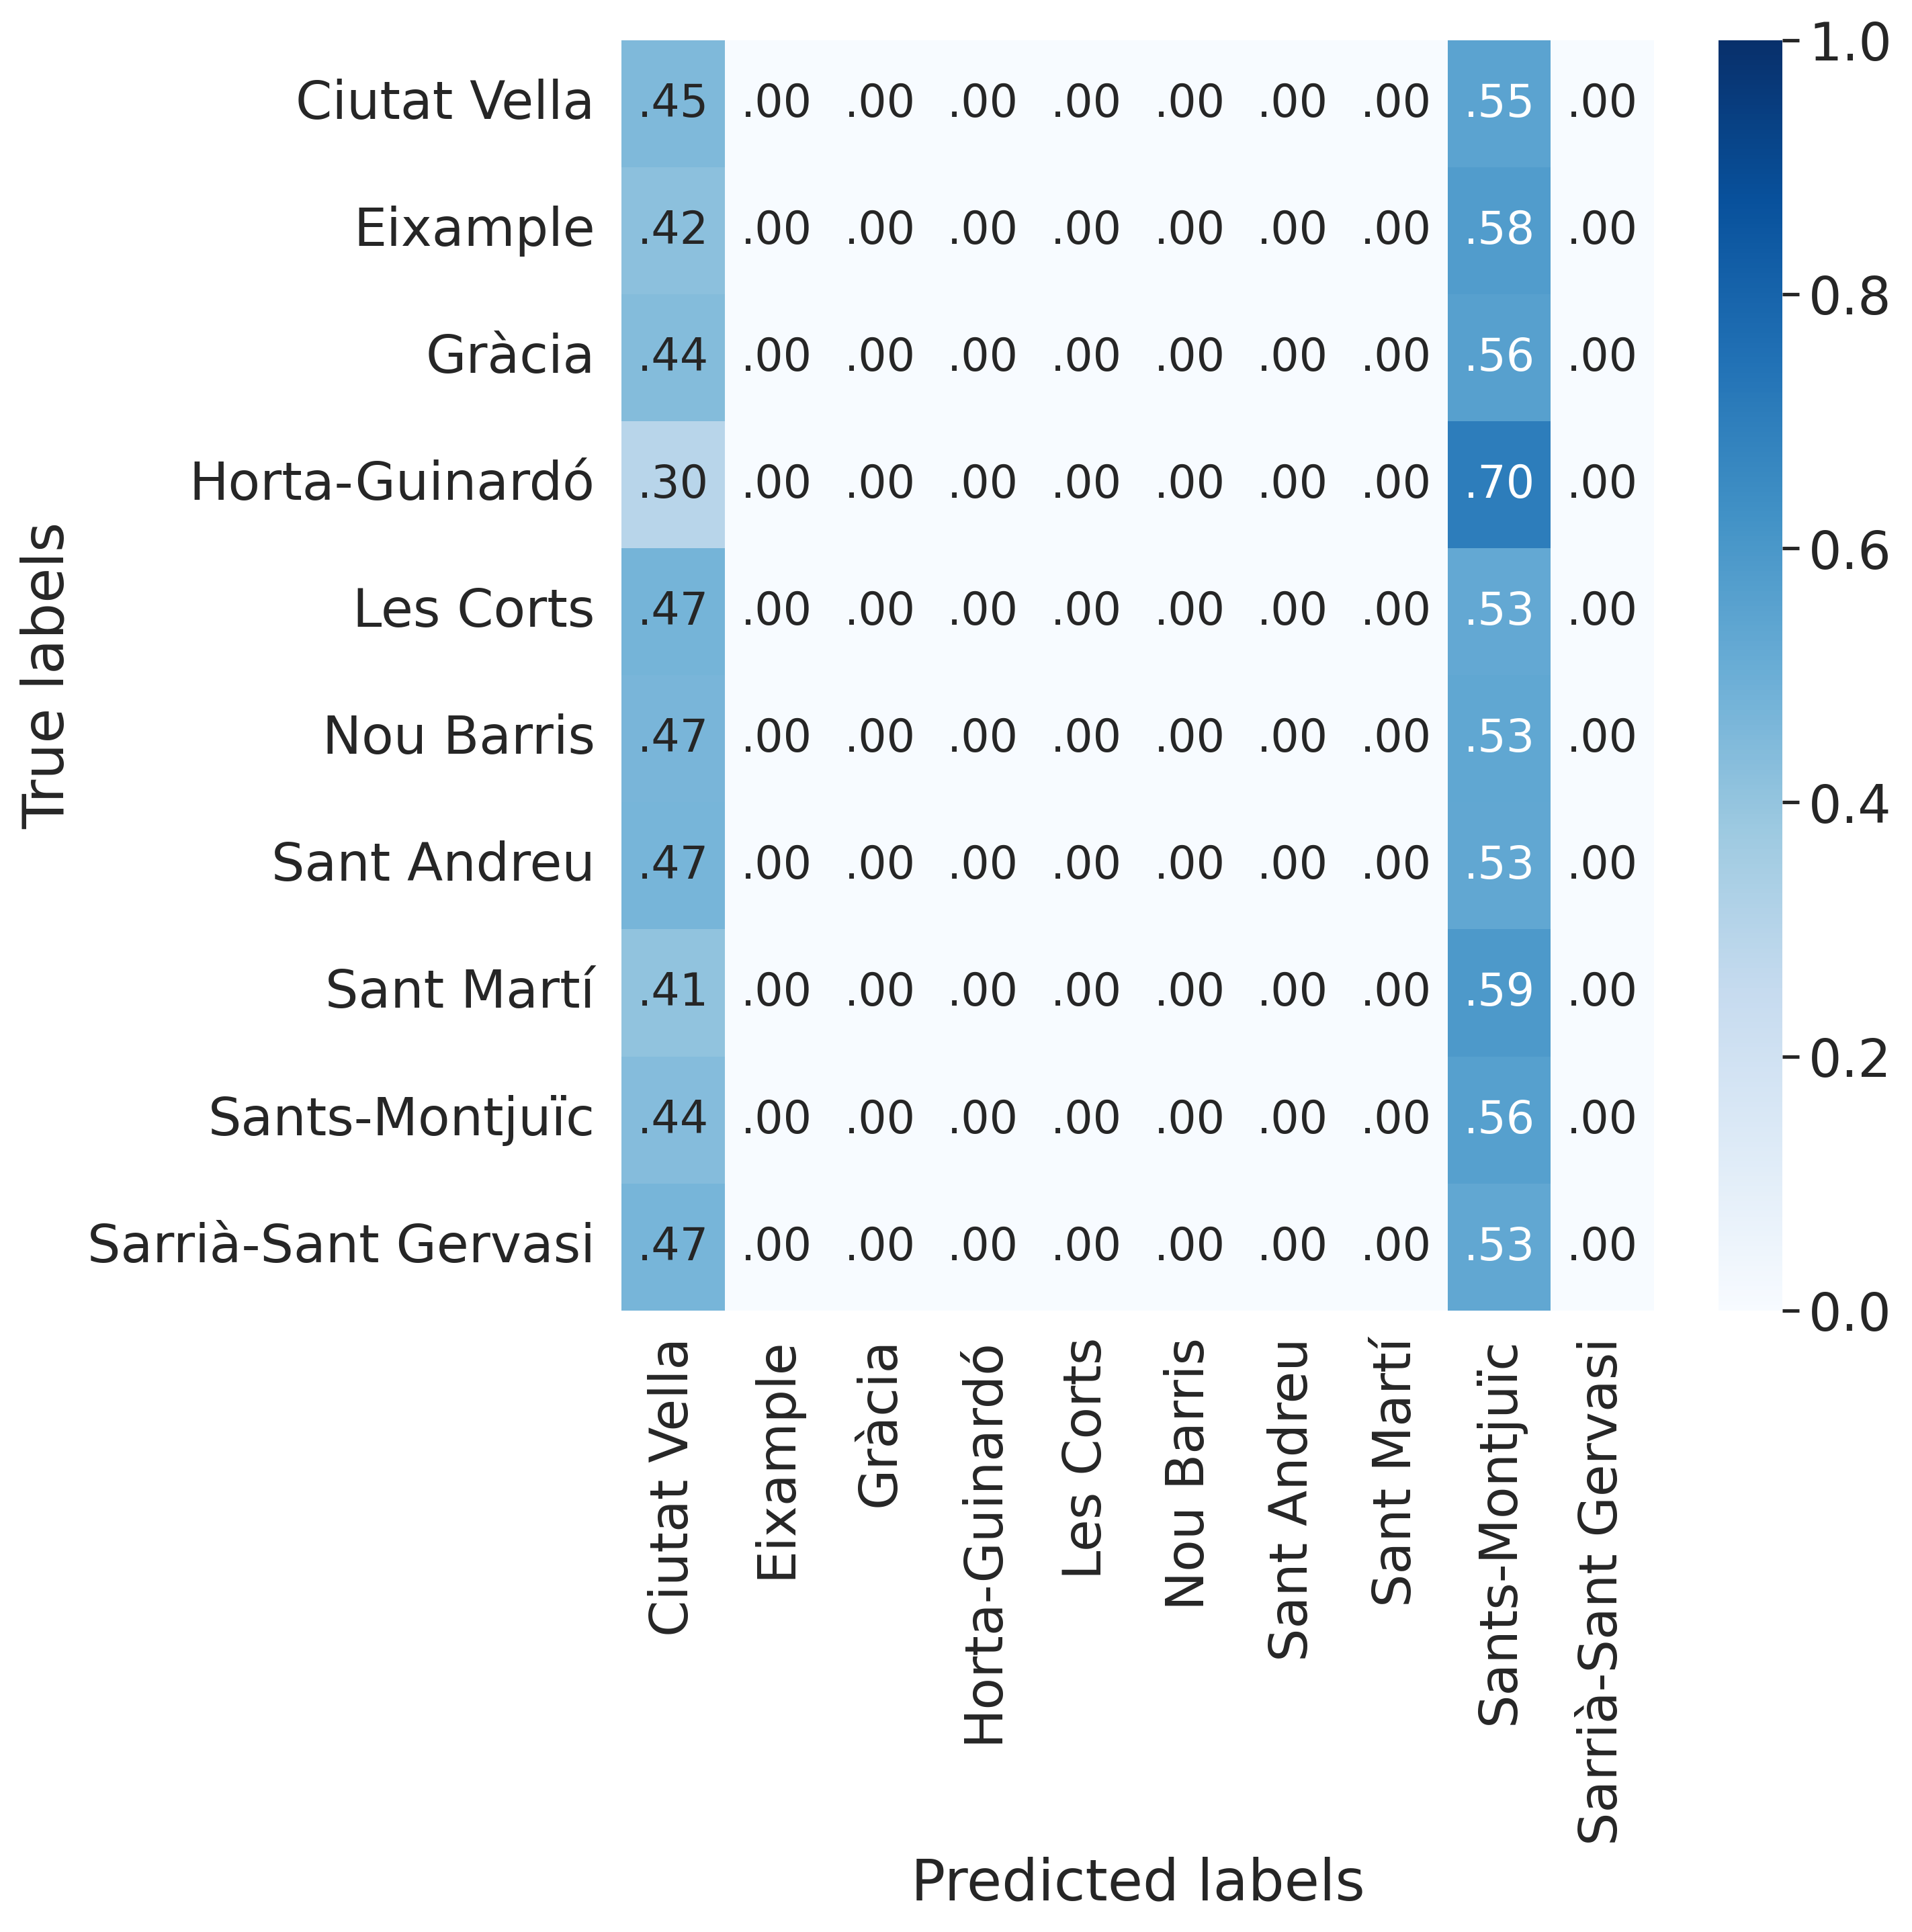

In [34]:
sn.set(font_scale=1.7)
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(cf_matrix, annot=cm_df, cmap='Blues', vmax=1, fmt='', annot_kws={"fontsize":16})  
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(sorted(target_names), rotation=90)
ax.yaxis.set_ticklabels(sorted(target_names), rotation=360)
plt.tight_layout()
# plt.savefig('img/flickr_cf.png')
plt.show()

___________
## Mapillary dataset

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
matplotlib.style.use('default')

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# first download dataset into "mapillary" folder
train_generator = train_datagen.flow_from_directory(
    'mapillary/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'mapillary/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 163925 images belonging to 10 classes.
Found 17663 images belonging to 10 classes.


In [8]:
# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
# Define early stopping for the model training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [10]:
# Clear any logs from previous runs
!rm -rf ./logs/

# Set up a log folder in which we will store the output to be displayed on TensorBoard
logdir = os.path.abspath("logs_cnn/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir)

In [11]:
# Fit data to model

history = model.fit(train_generator,
                    steps_per_epoch= len(train_generator.classes) // batch_size,
                    epochs=no_epochs,
                    validation_data=validation_generator,
                    verbose=verbosity,
                    callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50


2022-06-15 11:05:48.360939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-06-15 11:05:49.181371: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-15 11:05:49.668313: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5122/5122 [==============================] - 508s 98ms/step - loss: 6.0512 - accuracy: 0.2498 - val_loss: 3.0451 - val_accuracy: 0.2389
Epoch 2/50
5122/5122 [==============================] - 502s 98ms/step - loss: 2.6340 - accuracy: 0.2971 - val_loss: 2.6224 - val_accuracy: 0.2541
Epoch 3/50
5122/5122 [==============================] - 500s 98ms/step - loss: 2.1480 - accuracy: 0.3624 - val_loss: 2.1296 - val_accuracy: 0.3943
Epoch 4/50
5122/5122 [==============================] - 501s 98ms/step - loss: 1.9553 - accuracy: 0.4330 - val_loss: 2.3253 - val_accuracy: 0.3588
Epoch 5/50
5122/5122 [==============================] - 498s 97ms/step - loss: 1.8859 - accuracy: 0.4734 - val_loss: 2.0452 - val_accuracy: 0.4473
Epoch 6/50
5122/5122 [==============================] - 499s 97ms/step - loss: 1.8502 - accuracy: 0.4960 - val_loss: 2.0321 - val_accuracy: 0.4507
Epoch 7/50
5122/5122 [==============================] - 498s 97ms/step - loss: 1.8261 - accuracy: 0.5106 - val_loss: 2.1319 - val

In [12]:
# Visualize the model
%tensorboard --logdir {logdir}

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

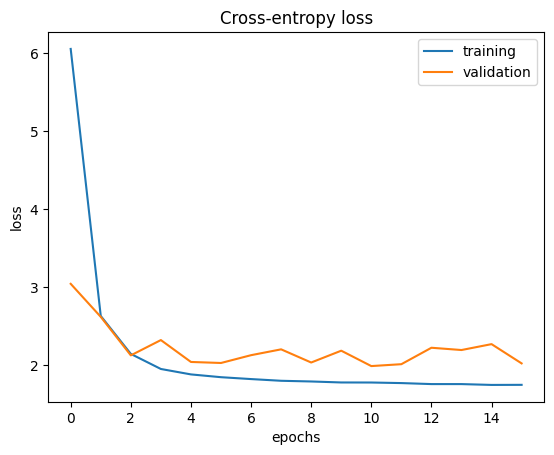

In [13]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Cross-entropy loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
# plt.savefig('img/mapillary_loss.png')
plt.show()

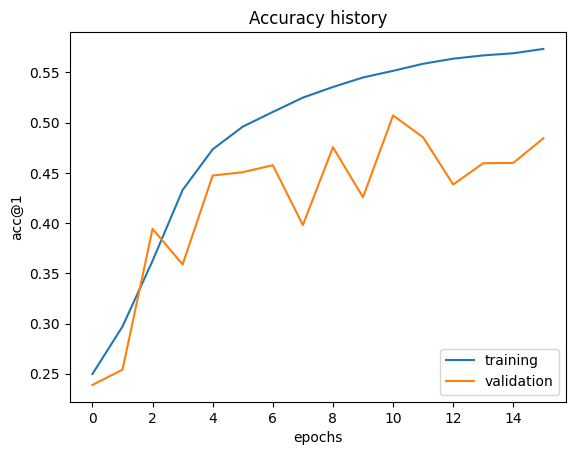

In [14]:
# Plot history: Accuracy
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy history')
plt.ylabel('acc@1')
plt.xlabel('epochs')
plt.legend(loc='lower right')
# plt.savefig('img/mapillary_acc@1.png')
plt.show()

In [15]:
score = model.evaluate(validation_generator, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.9925132989883423 / Test accuracy: 0.5071618556976318


## Confusion matrix

In [16]:
# first download dataset into "mapillary" folder
target_names = os.listdir('mapillary/val/')

In [17]:
y_prob = model.predict(validation_generator) 
y_pred = y_prob.argmax(axis=-1)

In [18]:
#Get the confusion matrix
cf_matrix = confusion_matrix(validation_generator.classes, y_pred, normalize='true')

print(cf_matrix)

[[0.14356191 0.07942773 0.00838678 0.17858905 0.14750863 0.
  0.02170696 0.3522447  0.06068081 0.00789344]
 [0.14107452 0.08908146 0.01039861 0.17088388 0.14211438 0.
  0.02357019 0.34627383 0.07140381 0.00519931]
 [0.14712644 0.07471264 0.00689655 0.17701149 0.15057471 0.
  0.03678161 0.33448276 0.06666667 0.00574713]
 [0.15931721 0.08297771 0.01090564 0.17449028 0.13608345 0.
  0.01801802 0.3371266  0.07396871 0.00711238]
 [0.13888889 0.08833333 0.01611111 0.17555556 0.165      0.00111111
  0.01833333 0.33222222 0.06111111 0.00333333]
 [0.13959391 0.06598985 0.02030457 0.18020305 0.17258883 0.
  0.02538071 0.31979695 0.07106599 0.00507614]
 [0.1438646  0.06488011 0.01551481 0.18335684 0.14668547 0.
  0.01974612 0.34132581 0.07757405 0.00705219]
 [0.13357576 0.07660606 0.01430303 0.17915152 0.14327273 0.00048485
  0.02521212 0.34933333 0.07418182 0.00387879]
 [0.13812785 0.10216895 0.01255708 0.16324201 0.1369863  0.
  0.02511416 0.34531963 0.06849315 0.00799087]
 [0.14717742 0.074596

In [19]:
cm_df = pd.DataFrame(cf_matrix)

for column in cm_df.columns:
    cm_df[column] = cm_df[column].apply(lambda x: f'{x:.2f}'.lstrip('0'))

cm_df

,0,1,2,3,4,5,6,7,8,9
0,.14,.08,.01,.18,.15,.00,.02,.35,.06,.01
1,.14,.09,.01,.17,.14,.00,.02,.35,.07,.01
2,.15,.07,.01,.18,.15,.00,.04,.33,.07,.01
3,.16,.08,.01,.17,.14,.00,.02,.34,.07,.01
4,.14,.09,.02,.18,.17,.00,.02,.33,.06,.00
5,.14,.07,.02,.18,.17,.00,.03,.32,.07,.01
6,.14,.06,.02,.18,.15,.00,.02,.34,.08,.01
7,.13,.08,.01,.18,.14,.00,.03,.35,.07,.00
8,.14,.10,.01,.16,.14,.00,.03,.35,.07,.01
9,.15,.07,.01,.17,.14,.00,.02,.36,.06,.00


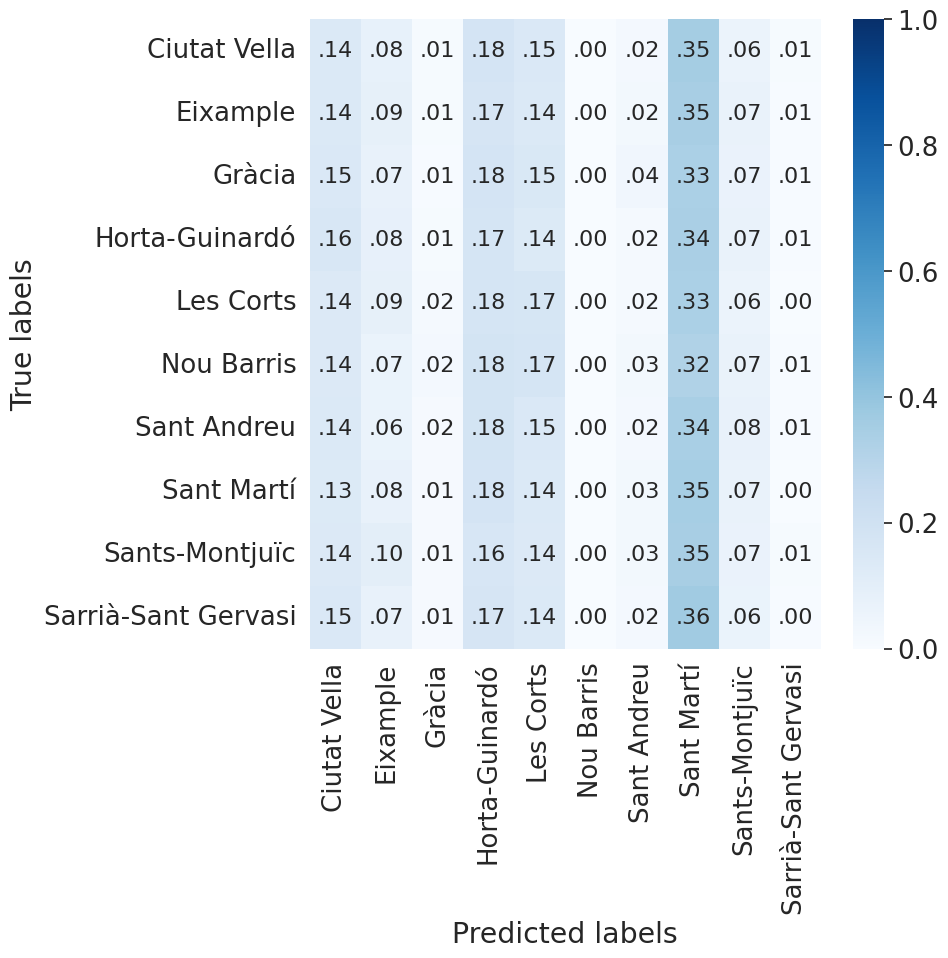

In [20]:
sn.set(font_scale=1.7)
fig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(cf_matrix, annot=cm_df, cmap='Blues', vmax=1, fmt='', annot_kws={"fontsize":16})  
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.xaxis.set_ticklabels(sorted(target_names), rotation=90)
ax.yaxis.set_ticklabels(sorted(target_names), rotation=360)
plt.tight_layout()
# plt.savefig('img/mapillary_cf.png')
plt.show()